In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from sdebridge import diffusion_bridge as db
from sdebridge import sdes

from sdebridge.utils import score_fn
from sdebridge.data_processing import sample_ellipse

from sdebridge.plotting import plot_single_trajectory
import matplotlib.pyplot as plt
import jax

In [3]:
T=1.
N=100
dim=2
num_pts = 5
sigma=1.0

forward_init = sample_ellipse(num_pts)
bm_sde = sdes.brownian_sde(T, N, dim, num_pts, sigma)

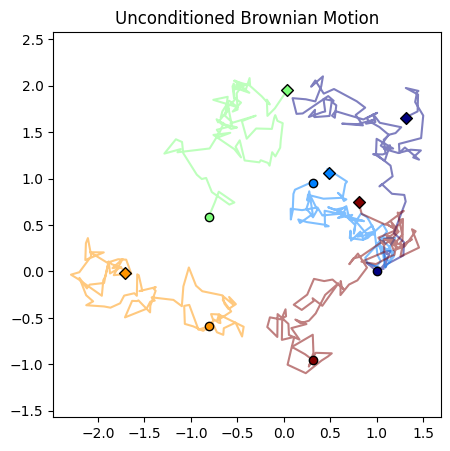

In [4]:
key = jax.random.PRNGKey(2)
forward_trajs = sdes.simulate_traj(bm_sde, forward_init, 2, key)
traj = forward_trajs[0].reshape((-1, num_pts*dim))
plot_single_trajectory(traj, "Unconditioned Brownian Motion")


In [6]:
from sdebridge.networks.score_unet import ScoreUNet

    
neural_net = ScoreUNet

network = {
    "output_dim": bm_sde.dim*bm_sde.n_bases,
    "time_embedding_dim": 32,
    "init_embedding_dim": 32,
    "act_fn": "silu",
    "encoder_layer_dims": [64, 32, 16, 8],
    "decoder_layer_dims": [8, 16, 32, 64],
    "batchnorm": True,
}
    # "neural_net": ScoreUNet,
    # "network": {
    #     "output_dim": bm.sde.dim*bm.sde.n_bases,
    #     "time_embedding_dim": 128,
    #     "init_embedding_dim": 256,
    #     "act_fn": "gelu",
    #     "encoder_layer_dims": [256, 256, 256],
    #     "decoder_layer_dims": [256, 256, 256],
    #     "batchnorm": False,
    # },
    
training= {
    "batch_size": 100,
    "load_size": 5000,
    "num_epochs": 50,
    "learning_rate": 5e-3,
    "warmup_steps": 0,
}


target = sample_ellipse(num_pts)
train_key = jax.random.split(key, 2)[0]
score_state_p = db.learn_p_score(bm_sde, target, train_key, **training, net=neural_net, network_params=network)

Training: 100%|██████████| 50/50 [02:28<00:00,  2.98s/epoch, Epoch=50, loss=0.0000]


In [7]:
initial_val = sample_ellipse(num_pts, scale=1.2)
score_p = score_fn(score_state_p)
reverse_bm = sdes.reverse(bm_sde, score_p)
backward_trajs = sdes.simulate_traj(reverse_bm, initial_val, 2, train_key)


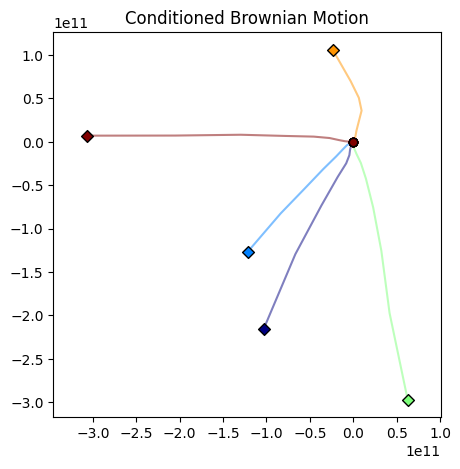

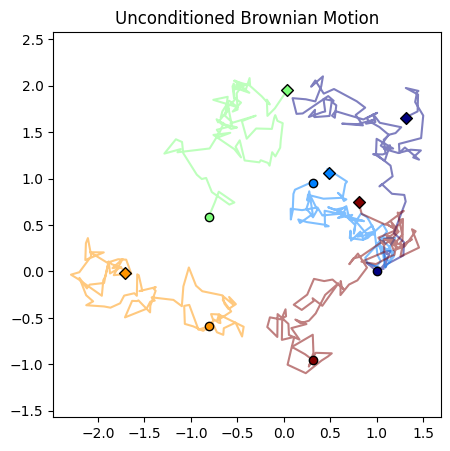

In [8]:
traj = backward_trajs[0].reshape((-1, num_pts*dim))
plot_single_trajectory(traj, "Conditioned Brownian Motion")

plt.scatter(target[:, 0], target[:, 1], c='r', label="Target")
plt.show()

traj = forward_trajs[0].reshape((-1, num_pts*dim))
plot_single_trajectory(traj, "Unconditioned Brownian Motion")